# Нейронные сети и мультиклассификация
Задание курса **Coursera ML with Andrew Ng**. Неделя 4.
Практическая реализация алгоритма нейросетей, использующих логистическую регрессию для мультиклассификации изображений письменных чисел. 
Для подбора оптимальных параметров $ \theta $ будут использоваться алгоритмы *градиентного спуска* и *нормализованного уравнения (normal equation)*, однако теперь с регулированием. 
## Подготовка датасетов

In [1]:
from scipy.io import loadmat
import numpy as np,math, pandas as pd, matplotlib.pyplot as plt,scipy.optimize as optimize,utils

%cd ~/Documents/ML/machine-learning-ex3/ex3/

mat = loadmat('ex3data1.mat')
X1 = np.array(mat['X'])
Y1 = np.array(mat['y'])
m,n = X1.shape

/Users/love/Documents/ML/machine-learning-ex3/ex3


Данные нам датасеты уже представлены в матричном виде $ \mathbb{R}^{m \times 400} $, мы можем самостоятельно узнать как выглядят картинки 20х20 (монохромные), составив изображения из массивов. Например, вот 100 случайных чисел из обработанной матрицы:

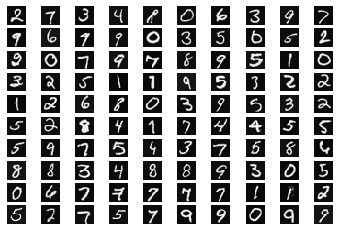

In [137]:
def draw_images(X, amount = 100):
    
    for i in range(1,amount +1):
        index = np.random.randint(0,4999)
        num = X[index,:].reshape(20,20).T
        
        ax = plt.subplot(10,10,i)
        ax.imshow(num, cmap="gray")
        plt.axis('off')
    
    plt.show()
draw_images(X1)

## Векторизация
Так как наша задача подразумевает 10 классов для распознания, крайне важно, чтобы логистическая регрессия была хорошо-оптимизирована и уж точно приведена к векторной форме.

Начнем с оптимизации стоимостной функции без регуляризации. В изначальном виде функция выглядела так:
$$ J(\vec{\theta}) = \frac{1}{m} \sum \limits _{i=1} ^{m} [-y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1-h_\theta(x^{(i)}))]$$

Так как $ y $ и $ h_\theta(X) $ имеют одинаковую размерность, упростить эту функцию достаточно просто:
$$ \vec{y} \in \mathbb{R}^{m \times 1}, \vec{h_\theta}(X) = g(X \vec{\theta}) \in \mathbb{R}^{(m \times n+1) \times (n + 1 \times 1)} \Longrightarrow J(\vec{\theta}) = \frac{1}{m} \sum [-\vec{y} \cdot \log(\vec{h}) - (1 - \vec{y})\cdot \log(1 - \vec{h})]$$
При этом добавления регуляризации тривиально: $ J(\vec{\theta}) = ... + \frac{\lambda}{2m} \mathbb{1} \times \vec{\theta}^2 $, за исключением того факта, что мы не регулируем `bias unit` — в матрице $ \mathbb{1} $ первый элемент будет равен нулю.

Также приведем диффуру к матричному виду и добавим регуляризацию:
$$ \frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum \limits _{i=1} ^{m} [h_\theta(x^{(i)} - y^{(i)})x_j^{(i)}] \Longrightarrow \frac{\partial J}{\partial \theta} = \frac{1}{m} \sum [(\vec{h} - \vec{y})^T \times X]  $$
И добавим регулирующее звено: $ \frac{\partial J}{\partial \theta} = ... + \frac{\lambda}{2m} \mathbb{1} \times \vec{\theta} $ 

In [89]:
def sigmoid(z):
    return 1/(1 + np.exp(-1 * z))
def hypothesis(X, theta):
    theta = theta.reshape(X.shape[1],1)
    z = X @ theta
    return sigmoid(z)

In [90]:
def cost(theta,X,y,regularization = None ):
    m,n = X.shape
#     print("TTT",theta.shape,X.shape)
    h = hypothesis(X,theta)
    h = h.reshape(m,1)
    errs = (-y * np.log(h) - (1 - y) * np.log(1 - h))
     
    if regularization != None:
        eye = np.eye(theta.shape[0])
        eye[0,0] = 0
        J_reg = (regularization / (2*m)) * np.sum((eye @ theta**2))
        d_reg = ((regularization / m) * (eye @ theta)).reshape(n,1)
    else:
        J_reg = 0
        d_reg = 0
    
    J = 1 / m * np.sum(errs) + J_reg
    dtheta = 1 / m *(X.T @ (h - y)) + d_reg
    return J,dtheta

In [5]:
yy = np.array([1,0,1,0,1]).reshape(5,1)
XX = np.concatenate((np.ones(5).reshape(5,1),(np.arange(1,16)/10).reshape(3,5).T),1)
the = np.array([-2,-1,1,2]).T
the = the.reshape((len(the),1))
J, dtheta = cost(the, XX,yy,3)
print("Cost function is %.3f with 0 params" %J)
print(dtheta)

Cost function is 2.535 with 0 params
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


## One-vs-all мультиклассификация
Однако мы еще не можем оптимизировать параметры датасета — $ y \in \{0-9\} $, в то время, как используемая стоимостная функция реализована для $ y \in \{0,1\} $. Мы можем обойти ограничение используя метод `one vs all` или `one-hot encoding`.
Функция будет возвращать $K$ определителей `classifiers` — матрицу $ \Theta \in \mathbb{R}^{K \times (n + 1)}$

In [101]:
def gradient(X, y, theta, alpha, num_iters, regulator = None):
    m, n = X.shape
    J_history = np.zeros((num_iters,1))
    
    for i in range(num_iters):
        J, delta = cost(theta, X,y, regulator)
        theta = theta.reshape(n,1) - alpha * delta
        J_history[i] = J
    return (J, J_history,theta)

In [183]:
def one_vs_all(X,y,k,reg = None):
    X = np.concatenate((np.ones((X.shape[0],1)),X),1)
    m,n = X.shape
    
    Theta = np.zeros((k, n))
    Jk = np.zeros(k)
    
    for i in range(k):
        number = np.array( y == i, dtype=int)
        
        J, hist, theta = gradient(X,number,Theta[i,:],3,500,reg)
        Theta[i,:] = theta.reshape(n)
        Jk[i] = J
    print(Jk)
    return Theta

In [184]:
Theta = one_vs_all(X1,Y1,10,0.1)

[0.00038165 0.02500154 0.06568761 0.06941972 0.04904771 0.07214985
 0.03220683 0.04394112 0.09036455 0.08571638]


Теперь у нас есть все параметры $\Theta \in \mathbb{R}^{K \times (n+1)}$, мы можем без проблем составить предсказывание письменных чисел:

In [202]:
def predictAll(Theta, X):
    X = np.concatenate((np.ones((X.shape[0],1)),X),1)
    H = sigmoid(X @ Theta.T)
    predicts = H.argmax(axis=1)
    
    print(Theta.shape)
    print(H[1,:])
    
    return predicts
predicts = predictAll(Theta,X1)


number = np.array(Y1 == 0, dtype=int)
X = np.concatenate((np.ones((X1.shape[0],1)),X1),1)
cost(Theta[0,:], X,number, 3)


# aa = np.concatenate((predicts.reshape(5000,1),Y1),1)
# pd.DataFrame(aa)

# predicts
# pd.DataFrame(predicts)

# print(np.sum(predicts == Y1)/len(predicts))

(10, 401)
[1.20319786e-15 2.08897844e-08 5.53836405e-05 3.78107129e-04
 6.76937871e-08 5.44263586e-03 5.48247695e-07 1.72390965e-04
 3.12619368e-06 4.68436400e-05]


(0.011443989432139551, array([[ 1.40790461e-07],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [-1.35302727e-10],
        [ 1.64366413e-09],
        [ 3.12712365e-09],
        [-1.02458465e-07],
        [-1.26986726e-07],
        [-7.02910908e-08],
        [-1.69515587e-08],
        [-3.80900117e-08],
        [-1.23178251e-08],
        [ 9.47405635e-09],
        [ 2.05322328e-08],
        [ 3.64743948e-08],
        [ 5.70788988e-08],
        [ 4.11978303e-08],
        [ 1.19778615e-08],
        [ 8.10038182e-11],
        [-1.27854241e-10],
        [ 0.00000000e+00],
        [-4.31136394e-11],
        [ 3.47886169e-10],
        [ 1.45705126e-09],
        [ 4.47995056e-09],
        [ 2.49784257e-08],
        [-1.43278309e-07],
        [-5.21160955e-07],
        [-7.82417390e-07],
        [-6.17475961e-07],
        [-2.34488197e-07],
        [ 8.87812509e-08],
        [ 1.87944084e-07],
        [ 2.13929540e-07],
        [ 2.52143814e-07],
        [ 8.26097091e-08],
      

In [188]:
aa = np.array([[1,3,2],[5,1,1],[2,9,1]])
aa.argmax(axis=1)

array([1, 0, 1])